In [1]:
import pandas as pd
import numpy as np
import re
import matplotlib.pyplot as plt
import os
from scipy.linalg import circulant
from numpy import linalg as LA
import preprocess as pr
from keras.preprocessing import sequence
import keras
from keras.models import Sequential,Model
from keras.layers import Dense,Input,Conv1D,MaxPooling1D,Flatten,LSTM,Dropout,BatchNormalization,Activation,Concatenate

from keras.preprocessing import sequence
import re

Using TensorFlow backend.


In [2]:
os.chdir("/Polycarbon/hand Motion Clasification")

In [5]:
class_num = [1,5,6,9,10,14,15]

In [3]:
def read_in_folder(folder_path,gesture_name):
    x=[]
    y=[]
    for file in os.listdir(folder_path):
        if( "-L-" in file): 
            L_hand_file=  folder_path +"/"+file
            R_hand_file=  folder_path +"/"+ re.sub(r"-L-","-R-",file)
            dL=pr.read_emg(L_hand_file).dropna().astype(float)
            dR=pr.read_emg(R_hand_file).dropna().astype(float)
            if(gesture_name!="1"):
                if(dL.Time.size>900):
                    T1 =  pr.find_active_time(dL.Time,dL.loc[:,['gx','gy','gz']])
                    T2 =  pr.find_active_time(dR.Time,dR.loc[:,['gx','gy','gz']])
                    if (len(T1)==2):
                        T = (np.array(T1)+np.array(T2))/2
                        Lhand = dL[dL.Time>=T[0]].T.values[1:]
                        Rhand = dR[dR.Time>=T[0]].T.values[1:]
                        x.append([Lhand,Rhand])
                        y.append(gesture_name)
            else:
                Lhand = dL.T.values[1:]
                Rhand = dR.T.values[1:]
                x.append([Lhand,Rhand])
                y.append(gesture_name)
            #print("success :"+L_hand_file+"__"+R_hand_file)
    return x,y

x = []
y = []
for n,sample in enumerate(os.listdir("Data/")[10:20]):
    if(os.path.isdir("Data/"+sample) and sample!=".ipynb_checkpoints"):
        for i in range(1,16):
            filename = "M"+str(i)+"-"+sample  
            if len(os.listdir("Data/"+sample+"/"+filename))==2:
                for fd in os.listdir("Data/"+sample+"/"+filename):
                    filepath="Data/"+sample+"/"+filename+"/"+fd+"/"
                    u,v = read_in_folder(filepath,str(i)+fd.lower())
                    x.extend(u)
                    y.extend(v)
            else:
                filepath="Data/"+sample+"/"+filename
                u,v = read_in_folder(filepath,str(i))
                x.extend(u)
                y.extend(v)
    print("success "+str(n)+"/105 "+":"+sample)

success 0/105 :Buntean


C:\Users\Denice\Anaconda3\envs\tensorflow\lib\site-packages\numpy\core\fromnumeric.py:2957: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
C:\Users\Denice\Anaconda3\envs\tensorflow\lib\site-packages\numpy\core\_methods.py:80: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)


success 1/105 :Buntra
success 2/105 :Charuves_Krasaerot
success 3/105 :Chatri
success 4/105 :Donsatid
success 5/105 :Duangporn
success 6/105 :Duenpen
success 7/105 :dusid
success 8/105 :Jamroen
success 9/105 :Jamroen_Murangkerd


In [4]:
y=np.array(y)

In [5]:
y=np.array(y)
y[y=="14left"]="14l"
y[y=="15left"]="15l"
y[y=="14right"]="14r"
y[y=="15right"]="15r"

In [6]:
from sklearn import preprocessing
encoder = preprocessing.LabelEncoder()
encoder.fit(y)
ye = encoder.transform(y)

In [7]:
encoder.classes_

array(['1', '10', '11', '12', '13', '14l', '14r', '15l', '15r', '2', '3',
       '4', '5', '6', '7', '8', '9'], dtype='<U3')

# Histogram of window lenght 

In [8]:
lenghts = [len(x[i][0][0]) for i in range(len(x))]
x=[x[i] for i,l in enumerate(lenghts) if(l>900 and l<3000)]
ye=[ye[i] for i,l in enumerate(lenghts) if(l>900 and l<3000)]

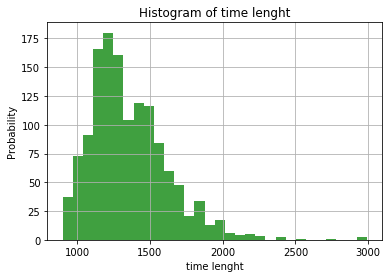

In [9]:

v = [len(x[i][0][0]) for i in range(len(x))]
# the histogram of the data
n, bins, patches = plt.hist(v, 30, density=False, facecolor='g', alpha=0.75)

mu = np.std(v)
sigma = np.average(v)
plt.xlabel('time lenght')
plt.ylabel('Probability')
plt.title('Histogram of time lenght')
# plt.text(500, 150, r'$\mu='+str(np.trunc(mu))+',\ \sigma='+str(np.trunc(sigma))+'$')0
plt.grid(True)
plt.show()

# build model function

In [10]:
def build_model(window_length,feature_length):
    input_signal = Input(shape=(feature_length,window_length),name="input_signal")
    x = Conv1D(filters=32, kernel_size=3,activation='relu', padding='same')(input_signal)
    x = MaxPooling1D(2, padding='same')(x)
    x = Conv1D(filters=16, kernel_size=200,activation='relu', padding='same')(x)
    x = MaxPooling1D(2, padding='same')(x)
    x = Conv1D(filters=8, kernel_size=200,activation='relu', padding='same')(x)
    x = MaxPooling1D(2, padding='same')(x)
#     x = LSTM(100, return_sequences=False)(x)
#     x = Dropout(0.5)(x)
    x = Flatten()(x)


    x = Dense(output_dim = 80, init = 'uniform', activation = 'relu')(x)
    dense_out = Dense(17, activation="sigmoid" ,name ="output_Dense")(x)
    
    model=Model(inputs=[input_signal], outputs=[dense_out])
        
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

def build_model2(window_length,feature_length):
    input_signal = Input(shape=(feature_length,window_length),name="input_signal")
    x = LSTM(100, return_sequences=False)( input_signal)
    
    x = Dropout(0.5)(x)

    x = Dense(output_dim = 80, init = 'uniform', activation = 'relu')(x)
    dense_out = Dense(9, activation="sigmoid" ,name ="output_Dense")(x)
    
    model=Model(inputs=[input_signal], outputs=[dense_out])
        
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
    return model

In [158]:
len(x[0][0])

30

In [11]:
# #normalize
# g=np.array([normalize(x[0]) for i in range(len(y))])
#padding
XL=np.array([sequence.pad_sequences(b[0], padding="post",maxlen=2000,dtype='float64')for b in x])
XR=np.array([sequence.pad_sequences(b[1], padding="post",maxlen=2000,dtype='float64')for b in x])

In [20]:
X =np.concatenate((XL[:,16:], XR[:,16:]), axis=1)


In [13]:
ye=np.array(ye)

In [27]:
from sklearn.preprocessing import normalize
for gt in range(encoder.classes_.size):
    for ch in range(len(X[0])):      
        X[ye==gt][:,ch] = normalize(X[ye==gt][:,ch])

In [27]:
#ye = np.array(ye)
X[ye==1][:,0].shape

(20, 2000)

# feature Selection

['Smooth-Ch0','Smooth-Ch1','Smooth-Ch2','Smooth-Ch3','Smooth-Ch4','Smooth-Ch5','Smooth-Ch6','Smooth-Ch7','ax','ay','az','gx','gy','gz']

In [34]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split( X,ye,test_size=0.2,stratify=ye)

model=build_model(X.shape[2],X.shape[1])  
model.fit(X_train, pd.get_dummies(y_train), batch_size = 500, nb_epoch = 100)


C:\Users\Denice\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `Dense` call to the Keras 2 API: `Dense(activation="relu", units=80, kernel_initializer="uniform")`
  
C:\Users\Denice\Anaconda3\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:5: UserWarning: The `nb_epoch` argument in `fit` has been renamed `epochs`.
  """


Epoch 1/100
1078/1078 [==============================] - 1s 1ms/step - loss: 2.8431 - acc: 0.0603
Epoch 2/100
1078/1078 [==============================] - 1s 500us/step - loss: 2.8083 - acc: 0.0538
Epoch 3/100
1078/1078 [==============================] - 1s 499us/step - loss: 2.7769 - acc: 0.1095
Epoch 4/100
1078/1078 [==============================] - 1s 502us/step - loss: 2.7266 - acc: 0.1568
Epoch 5/100
1078/1078 [==============================] - 1s 513us/step - loss: 2.6593 - acc: 0.1475
Epoch 6/100
1078/1078 [==============================] - 1s 522us/step - loss: 2.5485 - acc: 0.1818
Epoch 7/100
1078/1078 [==============================] - 1s 507us/step - loss: 2.3900 - acc: 0.2644
Epoch 8/100
1078/1078 [==============================] - 1s 501us/step - loss: 2.2645 - acc: 0.2746
Epoch 9/100
1078/1078 [==============================] - 1s 501us/step - loss: 2.0698 - acc: 0.3173
Epoch 10/100
1078/1078 [==============================] - 1s 504us/step - loss: 1.8952 - acc: 0.3646
E

In [35]:
scores = model.evaluate([X_test], pd.get_dummies(y_test))
print("\n%s: %.2f%%" % (model.metrics_names[1], scores[1]*100))

270/270 [==============================] - 0s 1ms/step

acc: 90.74%


Confusion matrix, without normalization
[[16  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 1 13  0  1  0  0  0  0  0  1  0  0  0  0  0  0  0]
 [ 0  0 12  0  0  0  0  0  0  2  0  0  0  0  0  1  0]
 [ 0  0  0 16  0  0  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  1  1 11  0  0  0  0  0  0  0  0  0  1  1  0]
 [ 0  0  0  0  0 16  0  0  0  0  0  0  0  0  0  0  0]
 [ 0  0  0  1  0  0 13  0  2  0  0  0  0  0  0  0  0]
 [ 0  0  1  0  0  1  1 11  0  1  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  1  0 16  0  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0 16  0  0  0  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  1 12  0  0  0  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  0 16  0  0  0  0  0]
 [ 0  0  0  0  0  1  0  0  0  0  0  0 15  0  0  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0 16  0  1  0]
 [ 0  0  0  0  0  0  0  0  0  0  1  0  1  0 14  0  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  0  0 16  0]
 [ 0  0  0  0  0  0  0  0  0  0  0  0  0  1  0  0 16]]


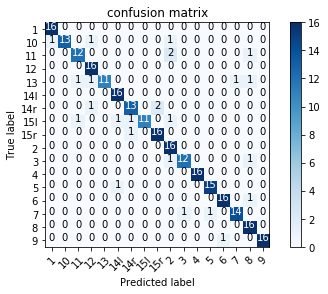

Normalized confusion matrix
[[1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.  ]
 [0.06 0.81 0.   0.06 0.   0.   0.   0.   0.   0.06 0.   0.   0.   0.
  0.   0.   0.  ]
 [0.   0.   0.8  0.   0.   0.   0.   0.   0.   0.13 0.   0.   0.   0.
  0.   0.07 0.  ]
 [0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.  ]
 [0.   0.   0.07 0.07 0.73 0.   0.   0.   0.   0.   0.   0.   0.   0.
  0.07 0.07 0.  ]
 [0.   0.   0.   0.   0.   1.   0.   0.   0.   0.   0.   0.   0.   0.
  0.   0.   0.  ]
 [0.   0.   0.   0.06 0.   0.   0.81 0.   0.12 0.   0.   0.   0.   0.
  0.   0.   0.  ]
 [0.   0.   0.07 0.   0.   0.07 0.07 0.73 0.   0.07 0.   0.   0.   0.
  0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.06 0.   0.94 0.   0.   0.   0.   0.
  0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   1.   0.   0.   0.   0.
  0.   0.   0.  ]
 [0.   0.   0.   0.   0.   0.   0.   0.   0.   0.07 0.86 0.   0.   0.
  0.   0.07 0.  ]
 [0.

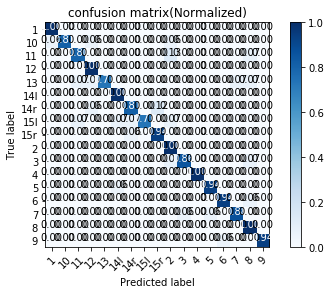

In [19]:
def get_predict(model,X):

    array_p=model.predict([X])
    predict=[np.argmax(i) for i in array_p]
    return  np.array(predict)

prd = get_predict(model,X_test)
pr.confuse_matrix_plot(y_test,prd,encoder.classes_,title="confusion matrix")

In [170]:
x1 =  x[10][0]

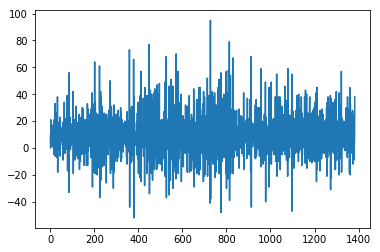

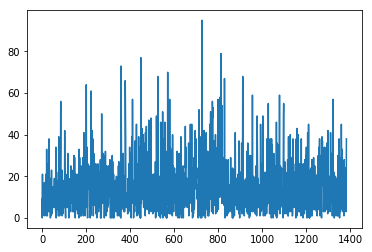

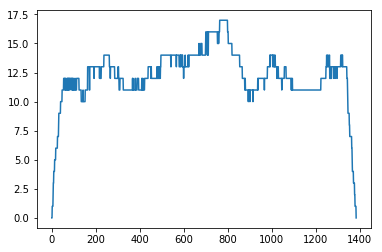

In [178]:
from scipy import signal
x1 =  x[11][0]
plt.plot(x1[0])
plt.show()
plt.plot(x1[8])
plt.show()
y1 = signal.medfilt(x1[8],101) 
plt.plot(y1)
plt.show()

In [198]:
len(x1[:8])
x1[:8]= [signal.medfilt(ch,21)  for ch in x1[:8]]           

In [202]:
X.shape

(6890, 28, 1000)

In [60]:
from sklearn.metrics import confusion_matrix
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def confuse_matrix_plot(Y,Pred,list_class,title="confusion matrix"):
    
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(Y, Pred)
    np.set_printoptions(precision=2)

    # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=list_class, normalize=False,
                          title=title)
    plt.show()
      # Plot normalized confusion matrix
    plt.figure()
    plot_confusion_matrix(cnf_matrix, classes=list_class, normalize=True,
                          title=title +'(Normalized)')
    plt.show()
